In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.neighbors import DistanceMetric
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import statsmodels.api as sm
import statsmodels.formula.api as smf
from math import pi
import numpy as np

%matplotlib inline
plt.style.use('seaborn')
pd.set_option('display.max_columns', 99)

/Users/adamszabunio/anaconda/envs/special_topics/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
df = pd.read_csv("ts_centroids_corn.csv", index_col=0)
df.fips_code = df.fips_code.astype(str).apply(lambda x: x.zfill(5))
df.set_index('fips_code', inplace=True)

a = pd.read_csv("year_counts_corn.csv")
a.fips_code = a.fips_code.astype(str).apply(lambda x: x.zfill(5))
a.set_index('fips_code', inplace=True)

full_data = df[df.index.isin(a[a.year_count==47].index.values)]
full_data.head()

,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,longitude,latitude
fips_code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
01049,35.0,56.0,61.2,61.7,56.0,63.0,75.0,29.0,42.1,80.3,17.6,38.7,63.9,54.7,88.4,96.2,49.3,79.8,41.8,90.0,60.6,85.6,123.7,53.8,109.9,65.0,92.0,86.0,74.0,101.0,80.0,117.0,84.0,100.0,136.0,129.0,58.0,80.0,71.0,117.0,87.0,129.7,103.5,140.5,144.3,151.0,96.8,-85.804109,34.459800
01077,25.0,42.0,51.4,55.5,40.0,50.0,50.0,36.0,66.4,51.6,40.3,76.7,79.4,52.0,70.0,84.9,70.0,77.9,34.5,79.3,35.9,54.5,104.0,54.7,96.2,95.0,80.0,76.0,61.0,100.0,95.0,128.0,99.0,145.0,135.0,112.0,84.0,92.0,99.0,130.0,126.5,124.8,75.7,154.6,184.4,161.6,106.5,-87.654010,34.901407
01079,30.0,45.0,52.5,54.4,34.0,42.0,53.0,33.0,30.3,42.6,20.0,69.7,69.6,41.1,67.9,74.5,75.0,65.7,31.1,83.3,44.3,78.6,109.2,65.6,110.9,92.0,82.0,108.0,68.0,136.0,99.0,138.0,115.0,153.0,151.0,136.0,77.0,73.0,98.0,112.0,143.0,132.5,78.6,172.0,187.1,140.3,117.2,-87.310989,34.521676
01083,33.0,44.0,47.3,49.0,40.0,44.0,68.0,38.0,71.7,71.9,47.3,67.5,75.8,61.0,71.7,101.6,69.3,58.2,30.3,82.2,41.2,70.2,119.1,66.7,93.9,94.0,90.0,86.0,71.0,112.0,86.0,146.0,107.0,150.0,150.0,139.0,85.0,100.0,122.0,142.0,144.5,128.3,71.9,159.3,181.7,170.8,112.9,-86.981401,34.810099
01089,33.0,51.0,56.7,61.1,54.0,75.0,79.0,35.0,61.3,74.9,25.2,55.4,96.0,55.9,78.5,98.1,63.3,71.2,45.9,80.0,49.3,82.0,98.9,50.0,116.7,104.0,93.0,83.0,68.0,121.0,88.0,118.0,102.0,125.0,137.0,143.0,90.0,100.0,153.0,128.0,113.9,147.9,110.6,161.6,169.0,173.2,150.7,-86.550226,34.763090


In [3]:
full_data.shape

(812, 49)

In [4]:
years = [i for i in full_data.columns if not i.startswith("l")]

In [5]:
X = full_data[years]
X.head()

,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
fips_code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
01049,35.0,56.0,61.2,61.7,56.0,63.0,75.0,29.0,42.1,80.3,17.6,38.7,63.9,54.7,88.4,96.2,49.3,79.8,41.8,90.0,60.6,85.6,123.7,53.8,109.9,65.0,92.0,86.0,74.0,101.0,80.0,117.0,84.0,100.0,136.0,129.0,58.0,80.0,71.0,117.0,87.0,129.7,103.5,140.5,144.3,151.0,96.8
01077,25.0,42.0,51.4,55.5,40.0,50.0,50.0,36.0,66.4,51.6,40.3,76.7,79.4,52.0,70.0,84.9,70.0,77.9,34.5,79.3,35.9,54.5,104.0,54.7,96.2,95.0,80.0,76.0,61.0,100.0,95.0,128.0,99.0,145.0,135.0,112.0,84.0,92.0,99.0,130.0,126.5,124.8,75.7,154.6,184.4,161.6,106.5
01079,30.0,45.0,52.5,54.4,34.0,42.0,53.0,33.0,30.3,42.6,20.0,69.7,69.6,41.1,67.9,74.5,75.0,65.7,31.1,83.3,44.3,78.6,109.2,65.6,110.9,92.0,82.0,108.0,68.0,136.0,99.0,138.0,115.0,153.0,151.0,136.0,77.0,73.0,98.0,112.0,143.0,132.5,78.6,172.0,187.1,140.3,117.2
01083,33.0,44.0,47.3,49.0,40.0,44.0,68.0,38.0,71.7,71.9,47.3,67.5,75.8,61.0,71.7,101.6,69.3,58.2,30.3,82.2,41.2,70.2,119.1,66.7,93.9,94.0,90.0,86.0,71.0,112.0,86.0,146.0,107.0,150.0,150.0,139.0,85.0,100.0,122.0,142.0,144.5,128.3,71.9,159.3,181.7,170.8,112.9
01089,33.0,51.0,56.7,61.1,54.0,75.0,79.0,35.0,61.3,74.9,25.2,55.4,96.0,55.9,78.5,98.1,63.3,71.2,45.9,80.0,49.3,82.0,98.9,50.0,116.7,104.0,93.0,83.0,68.0,121.0,88.0,118.0,102.0,125.0,137.0,143.0,90.0,100.0,153.0,128.0,113.9,147.9,110.6,161.6,169.0,173.2,150.7


In [6]:
y = X.pop("2016")
x = np.array(X)

In [7]:
x = sm.add_constant(x, prepend=True)
x

array([[   1. ,   35. ,   56. , ...,  140.5,  144.3,  151. ],
       [   1. ,   25. ,   42. , ...,  154.6,  184.4,  161.6],
       [   1. ,   30. ,   45. , ...,  172. ,  187.1,  140.3],
       ..., 
       [   1. ,   75. ,   91. , ...,  143.5,  182.8,  162.4],
       [   1. ,   75. ,   91. , ...,   98.5,  148.6,  144. ],
       [   1. ,   66. ,   83. , ...,  134.7,  149.5,  163.1]])

In [8]:
results = smf.OLS(y,x).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   2016   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     79.05
Date:                Sat, 16 Dec 2017   Prob (F-statistic):          3.64e-257
Time:                        22:01:20   Log-Likelihood:                -3236.6
No. Observations:                 812   AIC:                             6567.
Df Residuals:                     765   BIC:                             6788.
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         24.2926      5.083      4.779      0.000      14.315      34.271
x1            -0.2264      0.051     -4.475      0.000      -0.326      -0.127
x2             0.0864      0.065      1.327      0.185      -0.041       0.214
x3             0.1607      0.067      2.411      0.016       0.030       0.292
x4             0.0679      0.065      1.049      0.294      -0.059       0.195
x5            -0.1141      0.054     -2.115      0.035      -0.220      -0.008
x6             0.0324      0.055      0.590      0.555      -0.075       0.140
x7            -0.1110      0.041     -2.702      0.007      -0.192      -0.030
x8            -0.0241      0.039     -0.624      0.533      -0.100       0.052
x9             0.1901      0.060      3.162      0.002       0.072       0.308
x10            0.0414      0.069      0.600      0.549      -0.094       0.177
x11            0.0106      0.039      0.272      0.786      -0.066       0.087
x12            0.0498      0.056      0.887      0.375      -0.060       0.160
x13            0.0332      0.064      0.519      0.604      -0.092       0.159
x14           -0.0238      0.042     -0.560      0.576      -0.107       0.060
x15           -0.1353      0.051     -2.677      0.008      -0.235      -0.036
x16            0.0575      0.051      1.122      0.262      -0.043       0.158
x17           -0.1272      0.047     -2.710      0.007      -0.219      -0.035
x18            0.0962      0.047      2.027      0.043       0.003       0.189
x19           -0.1976      0.031     -6.377      0.000      -0.258      -0.137
x20           -0.0622      0.039     -1.601      0.110      -0.138       0.014
x21            0.0740      0.054      1.381      0.168      -0.031       0.179
x22            0.0785      0.034      2.291      0.022       0.011       0.146
x23           -0.0740      0.048     -1.545      0.123      -0.168       0.020
x24           -0.1212      0.032     -3.752      0.000      -0.185      -0.058
x25            0.0215      0.050      0.430      0.667      -0.077       0.120
x26            0.1060      0.049      2.145      0.032       0.009       0.203
x27            0.0529      0.047      1.132      0.258      -0.039       0.145
x28           -0.0787      0.049     -1.609      0.108      -0.175       0.017
x29            0.0641      0.041      1.548      0.122      -0.017       0.145
x30            0.0070      0.036      0.196      0.845      -0.063       0.077
x31            0.0143      0.035      0.410      0.682      -0.054       0.083
x32            0.0704      0.039      1.814      0.070      -0.006       0.147
x33            0.1743      0.031      5.694      0.000       0.114       0.234
x34           -0.0483      0.038     -1.285      0.199      -0.122       0.026
x35           -0.0557      0.043     -1.286      0.199      -0.141       0.029
x3

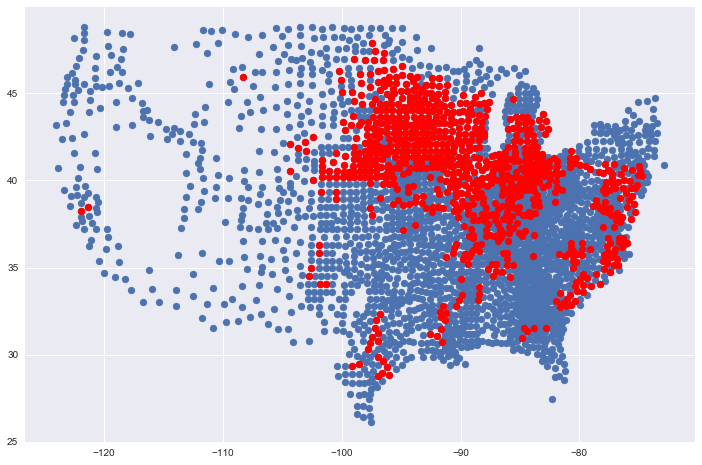

In [9]:
fig, ax = plt.subplots(figsize=(12, 8))
plt.scatter(df.longitude, df.latitude)
plt.scatter(full_data.longitude, full_data.latitude, c='r');

In [10]:
results.cov_params()

,const,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46
const,25.835901,0.005320,0.021123,0.005031,-0.017088,0.005835,0.068851,-6.137998e-03,-0.024549,0.003424,-0.044541,0.016286,-0.051333,-0.067541,-0.025336,0.016602,-0.027378,0.017785,-0.000447,0.005794,-0.002966,0.049545,-1.499681e-03,0.052150,-0.000996,-5.005746e-02,-0.042057,0.005256,-0.042254,0.024115,0.001965,-0.044281,-3.074259e-02,0.030523,0.036156,1.418851e-02,-0.009933,0.028271,8.742399e-03,0.024829,-0.027719,0.014297,0.012684,-0.018906,-0.032540,-0.050362,-0.028071
x1,0.005320,0.002560,-0.000440,-0.000142,-0.000304,-0.000423,0.000007,-8.522916e-05,0.000126,-0.000403,0.000314,-0.000187,-0.000277,0.000232,-0.000341,-0.000042,-0.000045,-0.000003,-0.000098,0.000191,-0.000046,-0.000693,4.995506e-05,0.000151,0.000015,1.972056e-04,-0.000166,0.000092,-0.000166,-0.000269,0.000077,-0.000061,4.355066e-04,0.000114,0.000085,-2.121205e-04,-0.000138,-0.000156,1.776018e-04,0.000107,0.000067,0.000037,-0.000017,-0.000178,0.000268,-0.000134,0.000002
x2,0.021123,-0.000440,0.004238,-0.001463,-0.000329,-0.000264,-0.000604,-2.414621e-04,-0.000273,-0.000065,-0.000070,-0.000002,-0.000111,-0.000260,0.000257,0.000041,0.000132,0.000010,-0.000469,0.000447,-0.000086,-0.000081,4.131686e-05,-0.000149,0.000224,-3.864946e-04,0.000301,0.000079,-0.000631,-0.000042,-0.000043,-0.000005,2.182358e-05,-0.000164,0.000089,-1.568344e-05,0.000259,0.000123,-6.176592e-05,0.000034,-0.000175,-0.000118,-0.000036,0.000109,0.000113,-0.000070,0.000351
x3,0.005031,-0.000142,-0.001463,0.004443,-0.001810,0.000265,0.000018,-8.406130e-05,0.000137,-0.000008,-0.000865,-0.000243,0.000162,-0.000117,-0.000151,0.000262,-0.000050,-0.000210,0.000339,-0.000237,0.000087,0.000085,-9.268557e-05,-0.000015,0.000026,9.438090e-05,-0.000179,-0.000287,-0.000047,0.000074,-0.000292,0.000368,-1.209145e-04,0.000033,0.000128,1.243963e-04,-0.000169,0.000032,-2.469322e-04,0.000047,-0.000178,0.000411,-0.000016,0.000186,-0.000094,-0.000004,-0.000274
x4,-0.017088,-0.000304,-0.000329,-0.001810,0.004192,-0.000208,-0.000575,-1.554901e-04,0.000226,-0.000659,0.000463,0.000082,-0.000636,-0.000705,0.000272,0.000007,-0.000004,0.000006,-0.000051,-0.000034,-0.000088,0.000222,-1.996393e-04,-0.000142,0.000101,2.687647e-04,0.000173,-0.000133,0.000352,-0.000270,0.000269,-0.000063,3.332573e-04,-0.000359,0.000282,-1.944695e-04,-0.000308,0.000162,3.095797e-04,-0.000070,-0.000366,-0.000094,0.000135,0.000003,-0.000160,0.000139,0.000207
x5,0.005835,-0.000423,-0.000264,0.000265,-0.000208,0.002911,-0.000399,-4.329702e-04,-0.000164,-0.000158,-0.000263,-0.000336,-0.000258,-0.000410,0.000130,-0.000381,0.000247,0.000306,0.000082,-0.000182,0.000221,0.000350,-2.805160e-04,-0.000147,-0.000150,1.098771e-04,-0.000338,-0.000469,0.000232,0.000413,0.000232,-0.000154,-1.073124e-04,-0.000125,-0.000214,3.647777e-04,-0.000004,0.000035,-6.773108e-05,0.000106,0.000055,0.000084,0.000107,-0.000020,0.000036,0.000099,-0.000252
x6,0.068851,0.000007,-0.000604,0.000018,-0.000575,-0.000399,0.003017,-3.013756e-04,-0.000224,0.000076,-0.000912,0.000196,-0.000069,-0.000563,-0.000275,0.000013,-0.000069,0.000255,0.000218,0.000110,-0.000118,-0.000379,1.227365e-04,0.000298,-0.000312,-1.042694e-04,0.000165,0.000086,-0.000052,0.000329,-0.000044,-0.000174,-2.027146e-04,0.000320,-0.000415,6.972051e-05,0.000062,0.000031,-1.063315e-04,-0.000087,0.000445,0.000174,-0.000123,-0.000175,-0.000078,-0.000083,-0.000046
x7,-0.006138,-0.000085,-0.000241,-0.000084,-0.000155,-0.000433,-0.000301,1.689268e-03,-0.000119,-0.000022,-0.000443,-0.000014,-0.000022,0.000331,0.000017,-0.000356,-0.000067,0.000134,-0.000154,-0.000095,0.000083,0.000217,2.337614e-04,-0.000382,-0.000333,-1.328233e-05,0.000082,0.000171,0.000139,0.000128,0.000057,0.000118,-1.928821e-04,-0.000013,-0.000138,1.328583e-04,0.000027,-0.000241,4.023898e-07,0.000195,0.000165,0.000221,-0.000081,-0.000131,-0.000120,-0.000028,0.000038
x8,-0.0

In [11]:
lm = LinearRegression()

In [12]:
lm.fit(X[:-1], y[:-1])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [13]:
lm.coef_

array([-0.22940311,  0.08710657,  0.16098599,  0.06823288, -0.11396774,
        0.03285152, -0.10914354, -0.02394422,  0.18918982,  0.03692892,
        0.01211497,  0.05045533,  0.03515133, -0.0223727 , -0.13710251,
        0.0557811 , -0.12761346,  0.09694132, -0.19585107, -0.06342984,
        0.07562277,  0.07861426, -0.07549918, -0.12170262,  0.02242443,
        0.1044973 ,  0.05372864, -0.07642495,  0.06515262,  0.0062726 ,
        0.01489403,  0.0700854 ,  0.17340218, -0.04775638, -0.05468874,
       -0.05225052,  0.10459856,  0.12320642,  0.08550648,  0.08452259,
       -0.05997408,  0.06661344,  0.08882317,  0.06910308,  0.14098587,
        0.14603811])

In [14]:
lm.predict(X[-1:])

array([ 157.41045494])

In [15]:
y[-1:]

fips_code
56015    147.4
Name: 2016, dtype: float64

In [16]:
X = full_data[years]
X.head()

,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
fips_code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
01049,35.0,56.0,61.2,61.7,56.0,63.0,75.0,29.0,42.1,80.3,17.6,38.7,63.9,54.7,88.4,96.2,49.3,79.8,41.8,90.0,60.6,85.6,123.7,53.8,109.9,65.0,92.0,86.0,74.0,101.0,80.0,117.0,84.0,100.0,136.0,129.0,58.0,80.0,71.0,117.0,87.0,129.7,103.5,140.5,144.3,151.0,96.8
01077,25.0,42.0,51.4,55.5,40.0,50.0,50.0,36.0,66.4,51.6,40.3,76.7,79.4,52.0,70.0,84.9,70.0,77.9,34.5,79.3,35.9,54.5,104.0,54.7,96.2,95.0,80.0,76.0,61.0,100.0,95.0,128.0,99.0,145.0,135.0,112.0,84.0,92.0,99.0,130.0,126.5,124.8,75.7,154.6,184.4,161.6,106.5
01079,30.0,45.0,52.5,54.4,34.0,42.0,53.0,33.0,30.3,42.6,20.0,69.7,69.6,41.1,67.9,74.5,75.0,65.7,31.1,83.3,44.3,78.6,109.2,65.6,110.9,92.0,82.0,108.0,68.0,136.0,99.0,138.0,115.0,153.0,151.0,136.0,77.0,73.0,98.0,112.0,143.0,132.5,78.6,172.0,187.1,140.3,117.2
01083,33.0,44.0,47.3,49.0,40.0,44.0,68.0,38.0,71.7,71.9,47.3,67.5,75.8,61.0,71.7,101.6,69.3,58.2,30.3,82.2,41.2,70.2,119.1,66.7,93.9,94.0,90.0,86.0,71.0,112.0,86.0,146.0,107.0,150.0,150.0,139.0,85.0,100.0,122.0,142.0,144.5,128.3,71.9,159.3,181.7,170.8,112.9
01089,33.0,51.0,56.7,61.1,54.0,75.0,79.0,35.0,61.3,74.9,25.2,55.4,96.0,55.9,78.5,98.1,63.3,71.2,45.9,80.0,49.3,82.0,98.9,50.0,116.7,104.0,93.0,83.0,68.0,121.0,88.0,118.0,102.0,125.0,137.0,143.0,90.0,100.0,153.0,128.0,113.9,147.9,110.6,161.6,169.0,173.2,150.7


# Predict for only 2016, using all other years data

In [17]:
X_train = X.copy()
y_train = X_train.pop("2016")

preds = []

for i in range(X.shape[0]):
    x = X_train[:i].append(X_train[i+1:])
    y = y_train[:i].append(y_train[i+1:])
    lm = LinearRegression()
    lm.fit(x, y)
    y_pred = lm.predict(X_train[i:i+1])
    preds.append(y_pred[0])

In [18]:
X_train.tail()

,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
fips_code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
55133,79.0,102.0,93.0,75.0,76.9,87.4,51.1,98.5,91.1,96.1,109.8,104.1,106.3,100.9,95.6,70.3,123.7,120.3,53.3,121.3,118.6,110.0,98.6,106.1,148.2,100.0,115.0,133.0,140.0,123.0,123.0,114.0,117.0,120.0,132.0,141.0,156.0,143.0,119.0,135.0,152.4,147.6,96.7,153.3,169.9,165.8
55135,77.0,95.0,84.0,71.0,65.5,69.1,72.8,91.0,90.4,92.5,102.5,95.5,111.6,98.1,98.1,100.8,103.8,108.5,74.1,106.0,110.4,111.7,103.2,87.9,122.5,110.0,112.0,123.0,121.0,143.0,131.0,102.0,133.0,133.0,115.0,144.0,124.0,122.0,135.0,135.0,149.8,138.4,128.5,151.4,141.6,153.2
55137,75.0,91.0,93.0,89.0,72.5,62.6,71.6,97.9,93.3,92.8,93.4,120.3,103.9,84.8,107.0,120.1,117.2,113.3,78.2,106.2,109.7,117.1,102.4,88.0,128.1,99.0,106.0,120.0,116.0,133.0,131.0,122.0,130.0,109.0,112.0,156.0,121.0,136.0,131.0,150.0,145.2,172.9,118.1,143.5,182.8,162.4
55141,75.0,91.0,88.0,76.0,64.1,60.6,72.0,90.6,89.6,95.0,91.4,101.6,105.4,89.4,90.6,93.7,96.9,113.1,66.9,99.6,110.0,107.7,91.4,74.4,127.8,106.0,85.0,132.0,129.0,137.0,122.0,123.0,142.0,99.0,117.0,150.0,129.0,125.0,120.0,139.0,134.5,148.1,109.6,98.5,148.6,144.0
56015,66.0,83.0,94.0,87.9,78.6,85.1,93.1,94.0,89.5,89.8,102.9,113.3,109.2,110.5,105.4,100.0,119.7,117.7,130.8,96.9,128.0,126.0,101.0,82.0,130.4,107.0,131.0,139.0,135.0,122.0,137.0,131.0,119.0,134.0,134.0,147.0,133.0,128.0,133.0,145.0,130.8,138.4,146.4,134.7,149.5,163.1


In [19]:
lr_preds = preds.copy()
lr_preds[:5]

[130.28747748595143,
 153.18625047877822,
 135.37546086128324,
 152.55696670398498,
 160.12514011149068]

In [20]:
print("RMSE: {:.4f}".format(np.sqrt(mean_squared_error(y_train, preds))))
print("R2: {:.4f}".format(r2_score(y_train, preds)))

RMSE: 13.9650
R2: 0.8003


In [21]:
lr_years = {}

for year in X.columns.values:
    
    X_train = X.copy()
    y_train = X_train.pop(year)
    preds = []

    for i in range(X.shape[0]):
        x = X_train[:i].append(X_train[i+1:])
        y = y_train[:i].append(y_train[i+1:])
        lm = LinearRegression()
        lm.fit(x, y)
        y_pred = lm.predict(X_train[i:i+1])
        preds.append(y_pred[0])
        
    lr_years[year] = preds

In [22]:
lin_reg_preds_df = pd.DataFrame(lr_years)
lin_reg_preds_df.index = full_data.index

lin_reg_preds_df.head()

,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
fips_code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
01049,34.878774,51.888205,66.856414,52.302086,43.822660,53.887796,81.317241,24.314715,64.102936,68.662254,26.131357,63.385592,75.403814,45.572199,79.498864,88.379019,55.442176,72.471624,64.519932,78.117175,66.687334,67.911843,102.013239,66.130405,98.214737,88.439545,101.176153,94.901052,57.487226,90.771524,86.710617,106.195850,57.048606,118.449824,116.956117,122.723584,87.794723,72.459977,99.423751,126.589876,95.753086,94.348887,79.546470,135.226440,147.678679,134.020398,130.287477
01077,29.489680,41.911784,51.888486,51.707658,48.706840,39.371084,59.626334,41.118694,49.662944,72.953266,29.673262,53.903519,80.562100,40.600445,66.851914,81.190883,70.912326,66.001588,60.894046,83.128353,58.036531,71.867592,95.875821,75.468330,103.861502,90.706820,84.062420,81.089203,70.468265,99.525898,104.292505,115.987906,80.773465,124.266386,138.827057,115.383191,97.902215,103.185097,104.300493,119.490262,124.880527,97.704496,76.264849,156.550096,139.369587,148.229899,153.186250
01079,18.669942,46.937137,50.098265,44.887353,31.843276,39.914205,45.087882,24.493876,48.113837,63.160632,23.572864,50.598931,75.295403,54.631611,61.135832,83.443544,60.253916,79.712593,44.901421,77.174702,56.988133,79.941668,90.242757,85.787088,107.863120,111.371031,85.866212,90.991874,81.403302,111.583806,104.965725,122.102978,109.424227,123.887164,141.015439,133.145549,104.889525,107.863188,110.084561,123.966236,109.488103,101.266394,82.495403,162.353010,160.945095,160.296572,135.375461
01083,24.225592,37.772519,61.152524,49.164467,50.984332,45.832663,56.539411,41.466468,55.995909,76.256822,33.604182,61.273346,78.569713,46.498443,75.252969,82.866518,66.798440,83.829027,64.027706,74.552964,60.884015,66.635968,106.743307,79.206555,114.672475,92.514508,89.014474,88.211736,84.593135,110.626496,108.359561,114.267481,86.740387,134.196715,150.987409,115.838670,112.120271,101.127276,102.506065,136.957807,130.751062,121.646171,102.242176,164.114373,161.075300,154.019343,152.556967
01089,27.198668,47.894963,69.676023,59.218946,54.553874,60.277460,56.623096,34.035854,61.116206,76.807627,34.844998,74.168430,85.012118,52.345471,82.542330,85.194671,50.786639,79.063073,45.487995,82.193600,68.564216,70.589687,103.802720,82.657244,109.630966,89.146773,97.780945,93.288106,68.525392,110.314949,101.483098,122.582620,91.482624,141.298494,138.515216,124.554710,117.056914,105.354964,113.820767,128.126204,121.379555,137.259367,139.358266,160.024196,156.249097,152.658683,160.125140


# Save results (Using all years to predict the missing year)

In [23]:
lin_reg_preds_df.to_csv("lin_reg_preds.csv")

# Metrics for Linear Regression

In [24]:
def mape(y_pred,y_true):
    y_pred = np.asarray(y_pred)
    y_true = np.asarray(y_true)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [25]:
lin_reg_RMSE = np.sqrt(mean_squared_error(X, lin_reg_preds_df))
lin_reg_R2 = r2_score(X, lin_reg_preds_df)
lin_reg_MAPE = mape(X, lin_reg_preds_df)
lin_reg_MAE = mean_absolute_error(X, lin_reg_preds_df)

print("Linear Regression RMSE: {:.4f}".format(lin_reg_RMSE))
print("Linear Regression R2: {:.4f}".format(lin_reg_R2))
print("Linear Regression MAPE: {:.4f}".format(lin_reg_MAPE))
print("Linear Regression MAE: {:.4f}".format(lin_reg_MAE))

Linear Regression RMSE: 12.4791
Linear Regression R2: 0.7891
Linear Regression MAPE: 9.3443
Linear Regression MAE: 9.3494


# By year

In [26]:
lin_reg_r2 = {}
lin_reg_rmse = {}
lin_reg_mape = {}
lin_reg_mae = {}

for i in lin_reg_preds_df.columns:
    lin_reg_rmse[i] = np.sqrt(mean_squared_error(X[i], lin_reg_preds_df[i]))
    lin_reg_r2[i] = r2_score(X[i], lin_reg_preds_df[i])
    lin_reg_mape[i] = mape(X[i], lin_reg_preds_df[i])
    lin_reg_mae[i] = mean_absolute_error(X[i], lin_reg_preds_df[i])

In [27]:
lin_reg_metrics_df = pd.DataFrame({"RMSE": lin_reg_rmse, "R2": lin_reg_r2,
                                  "MAPE": lin_reg_mape, "MAE": lin_reg_mae})
lin_reg_metrics_df.head()

,MAE,MAPE,R2,RMSE
1970,7.801224,12.893243,0.797377,9.813996
1971,5.923464,8.504547,0.885080,7.725671
1972,5.793651,7.297607,0.881336,7.545127
1973,5.887720,7.567285,0.867323,7.737385
1974,7.282784,11.765036,0.791097,9.250335


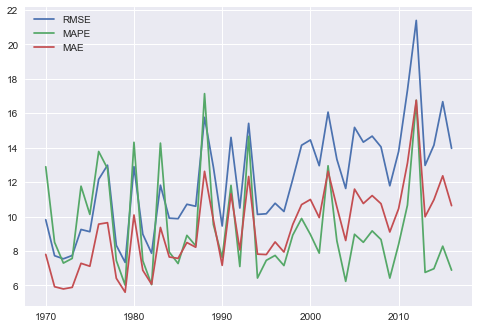

In [28]:
lin_reg_metrics_df[['RMSE', 'MAPE', 'MAE']].plot();

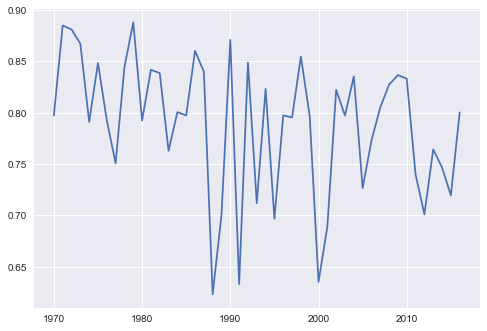

In [29]:
lin_reg_metrics_df['R2'].plot();

# Weighted LR (Haversine Distance)

In [30]:
full_spatial = full_data[['latitude', 'longitude']]

full_hav_df = full_spatial.copy()
full_hav_df = np.radians(full_hav_df)
full_hav_df.head()

,latitude,longitude
fips_code,,
01049,0.601437,-1.497564
01077,0.609144,-1.529851
01079,0.602517,-1.523864
01083,0.607551,-1.518112
01089,0.606730,-1.510586


In [31]:
dist = DistanceMetric.get_metric("haversine")
hav_dist_df = pd.DataFrame(dist.pairwise(full_hav_df))

In [32]:
# Predict for only 2016
X_train = X.copy()
y_train = X_train.pop("2016")
hav_weights = hav_dist_df.copy()
hav_weights = hav_weights.applymap(lambda x: x**-1 if x != 0 else 0)
hav_weights = hav_weights.apply(lambda x: x/sum(x), axis=1) # normalize
hav_preds = []

for i in range(X.shape[0]):
    x = X_train[:i].append(X_train[i+1:])
    y = y_train[:i].append(y_train[i+1:])
    w = hav_weights[i][:i].append(hav_weights[i][i+1:])
    lm = LinearRegression()
    lm.fit(x, y, w)
    y_pred = lm.predict(X_train[i:i+1])
    hav_preds.append(y_pred[0])

In [33]:
print("RMSE: {:.4f}".format(np.sqrt(mean_squared_error(y_train, hav_preds))))
print("R2: {:.4f}".format(r2_score(y_train, hav_preds)))

RMSE: 11.4520
R2: 0.8657


In [34]:
hav_preds[:5]

[124.5314980976637,
 140.64325168186537,
 116.86678683309384,
 140.92889577060956,
 146.50615314734841]

In [35]:
hav_lr_years = {}
hav_weights = hav_dist_df.copy()
hav_weights = hav_weights.applymap(lambda x: x**-1 if x != 0 else 0)
hav_weights = hav_weights.apply(lambda x: x/sum(x), axis=1) # normalize

for year in X.columns.values:
    
    X_train = X.copy()
    y_train = X_train.pop(year)
    hav_preds = []

    for i in range(X.shape[0]):
        x = X_train[:i].append(X_train[i+1:])
        y = y_train[:i].append(y_train[i+1:])
        w = hav_weights[i][:i].append(hav_weights[i][i+1:])
        lm = LinearRegression()
        lm.fit(x, y, w)
        y_pred = lm.predict(X_train[i:i+1])
        hav_preds.append(y_pred[0])
        
    hav_lr_years[year] = hav_preds

In [36]:
hav_lr_preds_df = pd.DataFrame(hav_lr_years)
hav_lr_preds_df.index = full_data.index

hav_lr_preds_df.head()

,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
fips_code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
01049,27.902637,52.445932,67.297112,55.625889,48.285510,53.571780,85.852464,28.975860,58.331131,66.981111,23.062686,59.017869,81.039413,49.790602,77.879410,89.962659,55.130107,64.682466,52.146015,86.134229,68.830965,79.053269,109.674796,53.620936,99.094987,84.639156,98.853868,91.092408,61.492669,93.090924,79.505520,109.344031,62.879014,123.974205,121.908047,127.981999,77.348050,64.644155,99.553221,113.960725,109.123760,99.523885,84.634786,130.195298,162.173647,148.657162,124.531498
01077,38.617261,43.563267,46.794848,52.509343,43.382102,39.899249,68.472678,41.633562,46.051332,67.462970,34.058176,54.818186,80.363143,37.425123,68.713859,83.016223,74.928934,55.219369,48.545195,85.842467,53.521117,75.787196,102.790784,68.044556,96.700888,87.117522,82.669111,83.883430,62.214521,107.256715,93.897341,126.966123,92.825035,135.144358,140.091107,125.908072,81.909348,95.965802,109.798307,120.573919,135.454644,105.566482,62.468190,152.046895,158.098684,146.357511,140.643252
01079,23.822073,43.649588,52.163683,45.217269,34.512172,41.074874,48.117288,20.517757,54.822522,58.720029,23.050958,53.224429,71.857516,60.613495,64.437749,90.189280,62.575954,79.480982,29.220561,80.573065,47.171798,75.119776,96.841179,78.505585,105.122299,114.433521,84.431167,86.010712,79.797618,112.950666,90.380994,135.650715,129.428039,131.748151,145.939808,137.745608,83.442194,97.917492,104.730098,123.534977,115.936697,117.937033,70.732633,163.127007,182.969512,168.352824,116.866787
01083,23.028385,36.838060,55.883251,51.478172,45.465982,52.404419,69.259070,38.729600,54.700585,64.530826,33.635219,72.034976,82.944968,47.328100,79.113793,83.555784,66.923041,85.240783,47.291157,75.855065,48.551539,72.931793,112.656037,64.593383,115.292253,92.100172,86.469203,86.748304,88.672875,117.902826,103.723649,116.285164,97.477227,142.141660,150.444763,122.724720,89.963840,84.746576,98.553230,137.241681,135.245236,138.146248,99.919761,162.861360,188.370413,157.881053,140.928896
01089,27.732110,51.253830,66.193724,58.591263,54.110228,59.076658,63.744098,33.436381,63.758434,77.036450,33.665828,75.733992,83.901081,59.674721,80.721468,91.997681,49.108141,73.844418,36.708618,88.872957,66.368052,77.296568,108.546517,70.104868,107.526346,86.832243,96.925721,91.137031,70.209446,108.015447,97.217801,131.811411,101.120917,142.091908,139.004610,132.086455,107.080958,98.648800,108.852059,121.615860,130.005774,144.865367,130.864291,163.287866,169.230776,154.668257,146.506153


In [37]:
hav_lr_preds_df.to_csv("lin_reg_haversine_norm_preds.csv")

In [38]:
hav_lr_RMSE = np.sqrt(mean_squared_error(X, hav_lr_preds_df))
hav_lr_R2 = r2_score(X, hav_lr_preds_df)
hav_lr_MAPE = mape(X, hav_lr_preds_df)
hav_lr_MAE = mean_absolute_error(X, hav_lr_preds_df)

print("Haversine Distance Normalized weighted Linear Regression RMSE: {:.4f}".format(hav_lr_RMSE))
print("Haversine Distance Normalized weighted Linear Regression R2: {:.4f}".format(hav_lr_R2))
print("Haversine Distance Normalized weighted Linear Regression MAPE: {:.4f}".format(hav_lr_MAPE))
print("Haversine Distance Normalized weighted Linear Regression MAE: {:.4f}".format(hav_lr_MAE))

Haversine Distance Normalized weighted Linear Regression RMSE: 9.9238
Haversine Distance Normalized weighted Linear Regression R2: 0.8660
Haversine Distance Normalized weighted Linear Regression MAPE: 7.4502
Haversine Distance Normalized weighted Linear Regression MAE: 7.3490


# By year

In [39]:
hav_lr_r2 = {}
hav_lr_rmse = {}
hav_lr_mape = {}
hav_lr_mae = {}

for i in hav_lr_preds_df.columns:
    hav_lr_rmse[i] = np.sqrt(mean_squared_error(X[i], hav_lr_preds_df[i]))
    hav_lr_r2[i] = r2_score(X[i], hav_lr_preds_df[i])
    hav_lr_mape[i] = mape(X[i], hav_lr_preds_df[i])
    hav_lr_mae[i] = mean_absolute_error(X[i], hav_lr_preds_df[i])

hav_lr_metrics_df = pd.DataFrame({"RMSE": hav_lr_rmse, "R2": hav_lr_r2,
                                  "MAPE": hav_lr_mape, "MAE": hav_lr_mae})
hav_lr_metrics_df.head()

,MAE,MAPE,R2,RMSE
1970,5.912849,9.860917,0.876236,7.670052
1971,4.916315,7.027171,0.921773,6.374084
1972,4.935170,6.217623,0.910508,6.552396
1973,4.845588,6.371879,0.906380,6.499506
1974,5.548971,9.062053,0.873486,7.198716


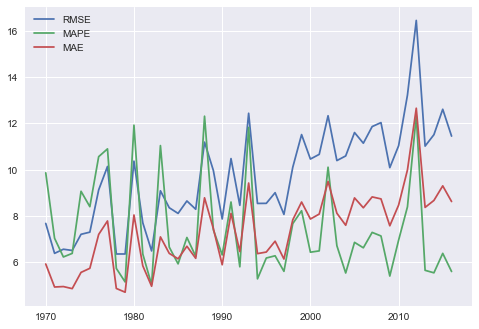

In [40]:
hav_lr_metrics_df[['RMSE', 'MAPE', 'MAE']].plot();

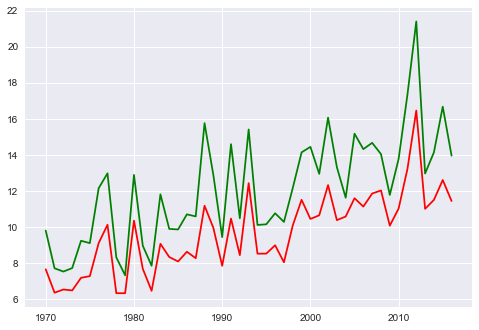

In [41]:
hav_lr_metrics_df['RMSE'].plot(c='r')
lin_reg_metrics_df['RMSE'].plot(c='g');

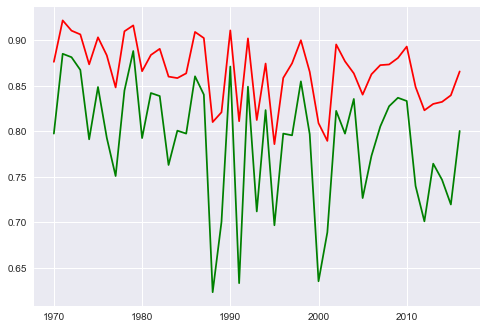

In [42]:
hav_lr_metrics_df['R2'].plot(c='r')
lin_reg_metrics_df['R2'].plot(c='g');

# Weighting by Distances (Exponential Smoothing)

In [43]:
# Predict for only 2016
X_train = X.copy()
y_train = X_train.pop("2016")
hav_weights = hav_dist_df.copy()
hav_weights = hav_weights.applymap(lambda x: x**-2 if x != 0 else 0)
hav_weights = hav_weights.apply(lambda x: x/sum(x), axis=1) # normalize
hav_preds2 = []

for i in range(X.shape[0]):
    x = X_train[:i].append(X_train[i+1:])
    y = y_train[:i].append(y_train[i+1:])
    w = hav_weights[i][:i].append(hav_weights[i][i+1:])
    lm = LinearRegression()
    lm.fit(x, y, w)
    y_pred = lm.predict(X_train[i:i+1])
    hav_preds2.append(y_pred[0])

In [44]:
print("RMSE: {:.4f}".format(np.sqrt(mean_squared_error(y_train, hav_preds2))))
print("R2: {:.4f}".format(r2_score(y_train, hav_preds2)))

RMSE: 11.8220
R2: 0.8569


In [45]:
hav_lr_years2 = {}
hav_weights2 = hav_dist_df.copy()
hav_weights2 = hav_weights.applymap(lambda x: x**-2 if x != 0 else 0)
hav_weights2 = hav_weights.apply(lambda x: x/sum(x), axis=1) # normalize

for year in X.columns.values:
    
    X_train = X.copy()
    y_train = X_train.pop(year)
    hav_preds = []

    for i in range(X.shape[0]):
        x = X_train[:i].append(X_train[i+1:])
        y = y_train[:i].append(y_train[i+1:])
        w = hav_weights[i][:i].append(hav_weights[i][i+1:])
        lm = LinearRegression()
        lm.fit(x, y, w)
        y_pred = lm.predict(X_train[i:i+1])
        hav_preds.append(y_pred[0])
        
    hav_lr_years2[year] = hav_preds

In [46]:
hav_lr_preds_df2 = pd.DataFrame(hav_lr_years2)
hav_lr_preds_df2.index = full_data.index

hav_lr_preds_df2.head()

,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
fips_code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
01049,25.309701,49.852021,67.162621,60.422386,50.533933,54.274923,82.113217,39.673496,50.662611,63.419005,26.026822,51.692533,86.161406,49.768733,75.265032,87.876633,54.720401,55.157873,46.546070,93.178141,72.393538,88.628171,115.515188,50.176323,101.032330,78.589820,97.225368,90.380899,56.833699,99.986567,82.051548,107.786134,69.077215,123.899944,126.131225,132.372710,78.058713,64.706978,105.421033,110.670862,111.180032,93.932216,88.262217,120.445137,163.224516,159.522046,128.959630
01077,45.099017,46.130442,42.308973,52.952054,40.936560,35.461317,69.853903,44.219464,43.604359,67.251004,39.105067,47.401068,81.408153,35.461106,66.827904,84.220847,77.260233,46.191793,45.648793,85.433885,58.962699,75.158680,104.356921,69.385920,88.503240,83.609241,81.223024,89.837766,50.248261,110.720972,84.956783,133.990611,96.564706,141.577061,139.403678,131.647899,84.649749,98.867389,125.259224,124.523545,137.531777,106.260919,50.129445,144.845546,167.612994,141.023928,134.832756
01079,25.932647,39.248131,60.230186,44.370273,39.176319,46.284223,43.754768,15.551363,62.555354,57.458266,23.065872,56.501232,65.166273,67.584620,65.787230,92.627656,60.015084,91.466783,27.188821,82.618303,41.179723,65.421785,99.821606,76.193338,104.479474,116.210541,83.972803,82.436937,83.192353,109.895428,93.683028,140.641189,132.312251,132.960687,147.434708,135.152325,70.738994,92.728723,91.846799,131.091055,114.991975,118.005340,69.171293,163.306670,191.082757,173.832089,119.939564
01083,15.068385,33.921911,55.290236,54.195274,40.494628,60.682916,69.740311,35.368367,56.807699,54.808882,33.016604,87.585347,87.454224,53.308600,85.906484,80.767010,64.251957,94.779899,36.168090,73.810027,39.050100,76.759489,112.805384,58.570820,117.648126,90.718768,86.986506,81.642516,94.862334,116.181646,104.182871,115.009958,99.296084,144.427940,149.106699,119.259046,86.740137,78.188740,87.132564,140.757570,129.924820,144.624728,108.093682,157.241783,203.444830,167.802078,135.925309
01089,27.698522,56.408168,66.430807,53.510768,53.484474,58.311020,68.399450,32.606105,70.236465,78.571332,36.887519,76.164655,79.653583,66.820959,78.966666,93.351975,50.047792,73.733248,41.171146,93.095015,66.935191,82.832347,109.052093,61.200126,109.196780,89.349379,97.051986,83.854941,71.998320,102.251949,96.727891,131.496273,105.076992,137.194619,140.654432,133.551549,100.269091,95.562161,107.275344,120.829078,132.037286,144.430006,126.614144,171.662063,171.776362,152.133797,138.389821


In [47]:
hav_lr_preds_df2.to_csv("lin_reg_hav_norm_exp2_df.csv")

In [48]:
hav_lr2_RMSE = np.sqrt(mean_squared_error(X, hav_lr_preds_df2))
hav_lr2_R2 = r2_score(X, hav_lr_preds_df2)
hav_lr2_MAPE = mape(X, hav_lr_preds_df2)
hav_lr2_MAE = mean_absolute_error(X, hav_lr_preds_df2)

print("Haversine Distance (1/x^2) Normalized weighted Linear Regression RMSE: {:.4f}".format(hav_lr2_RMSE))
print("Haversine Distance (1/x^2) Normalized weighted Linear Regression R2: {:.4f}".format(hav_lr2_R2))
print("Haversine Distance (1/x^2) Normalized weighted Linear Regression MAPE: {:.4f}".format(hav_lr2_MAPE))
print("Haversine Distance (1/x^2) Normalized weighted Linear Regression MAE: {:.4f}".format(hav_lr2_MAE))

Haversine Distance (1/x^2) Normalized weighted Linear Regression RMSE: 9.9173
Haversine Distance (1/x^2) Normalized weighted Linear Regression R2: 0.8659
Haversine Distance (1/x^2) Normalized weighted Linear Regression MAPE: 7.5248
Haversine Distance (1/x^2) Normalized weighted Linear Regression MAE: 7.2392


In [49]:
hav_lr2_r2 = {}
hav_lr2_rmse = {}
hav_lr2_mape = {}
hav_lr2_mae = {}

for i in hav_lr_preds_df.columns:
    hav_lr2_rmse[i] = np.sqrt(mean_squared_error(X[i], hav_lr_preds_df2[i]))
    hav_lr2_r2[i] = r2_score(X[i], hav_lr_preds_df2[i])
    hav_lr2_mape[i] = mape(X[i], hav_lr_preds_df2[i])
    hav_lr2_mae[i] = mean_absolute_error(X[i], hav_lr_preds_df2[i])

hav_lr2_metrics_df = pd.DataFrame({"RMSE": hav_lr2_rmse, "R2": hav_lr2_r2,
                                  "MAPE": hav_lr2_mape, "MAE": hav_lr2_mae})
hav_lr2_metrics_df.head()

,MAE,MAPE,R2,RMSE
1970,5.726571,10.102665,0.880409,7.539635
1971,4.940107,7.269992,0.917513,6.545341
1972,5.015179,6.368146,0.904029,6.785418
1973,4.806105,6.367291,0.903499,6.598764
1974,5.143006,8.689264,0.888428,6.760247


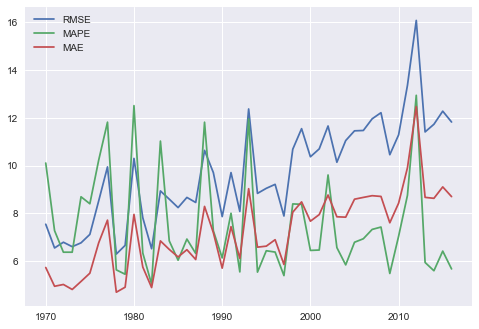

In [50]:
hav_lr2_metrics_df[['RMSE', 'MAPE', 'MAE']].plot();

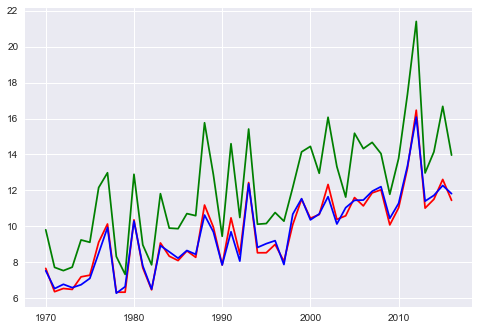

In [51]:
hav_lr_metrics_df['RMSE'].plot(c='r')
hav_lr2_metrics_df['RMSE'].plot(c='b')
lin_reg_metrics_df['RMSE'].plot(c='g');

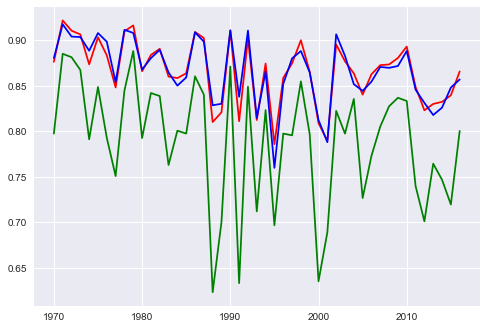

In [52]:
hav_lr_metrics_df['R2'].plot(c='r')
hav_lr2_metrics_df['R2'].plot(c='b')
lin_reg_metrics_df['R2'].plot(c='g');

___